# IP Adapter + Attn Mask -> visualization (Attention map)

In [1]:
import cv2
import numpy as np
import torch
from text_diffuser.generate_mask_only import gen_mask_only
from IPython.display import display
from PIL import Image
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
from diffusers.utils import load_image
from diffusers import DDPMScheduler, AutoencoderKL, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
from hi_sam.text_segmentation import make_text_segmentation_args
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import register_cross_attention_hook
from accelerate import PartialState

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    # "SG161222/Realistic_Vision_V6.0_B1_noVAE",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
distributed_state = PartialState()
pipe.to(distributed_state.device)
# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
        
    ],
)
pipe.set_ip_adapter_scale(0.25)

pipe.unet = register_cross_attention_hook(pipe.unet)

# input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))
hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')


""" Change the text in the original image by coordinates and  """

sample_text="A CUP OF COFFEE"
# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 

arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)


output = pipe(
    prompt="two rabbits, each hold a cup",
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image, input_image],
    width=512,
    height=512,
    guidance_scale=5,
    generator=generator,
).images[0]


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-05-31 16:20:31.974629: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 16:20:32.016666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:20:32.016703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:20:32.016730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuB

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Mask shape:  (512, 512)
torch.Size([512, 512])


  0%|          | 0/50 [00:00<?, ?it/s]

In IP Adapter Processor, hidden shape torch.Size([2, 4096, 320])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.0.attentions.0.transformer_blocks.0.attn2
In IP Adapter Processor, hidden shape torch.Size([2, 4096, 320])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.0.attentions.1.transformer_blocks.0.attn2
In IP Adapter Processor, hidden shape torch.Size([2, 1024, 640])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.1.attentions.0.transformer_blocks.0.attn2
In IP Adapter Processor, hidden shape torch.Size([2, 1024, 640])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.1.attentions.1.transformer_blocks.0.attn2
In IP Adapter Processor, hidden shape torch.Size([2, 256, 1280])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.2.attentions.0.transformer_blocks.0.attn2
In IP Adapter Processor, hidden shape torch.Size([2, 256, 1280])
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down

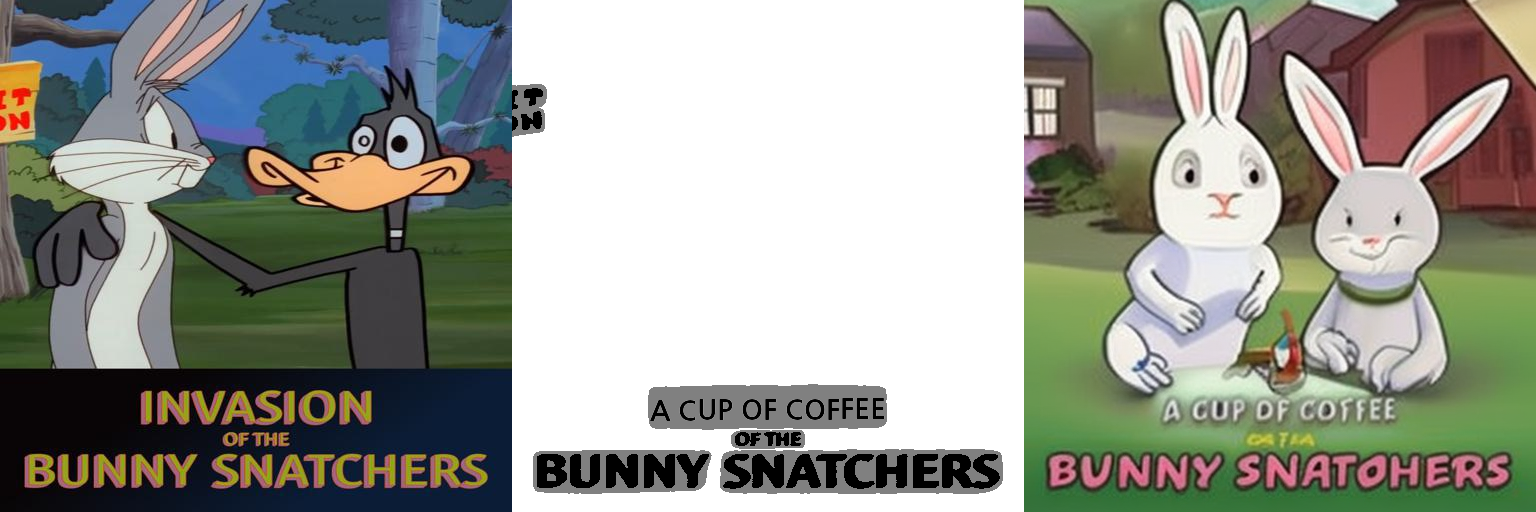

In [2]:
from diffusers.utils import make_image_grid
text_mask_pil = Image.fromarray(out)
# img_list = [input_image, text_mask_pil, tss_image, output]
img_list = [input_image, text_mask_pil, output]
resized_img_list = [img.resize((512,512)) for img in img_list]

img = make_image_grid(resized_img_list, rows=1, cols=len(resized_img_list))
display(img)

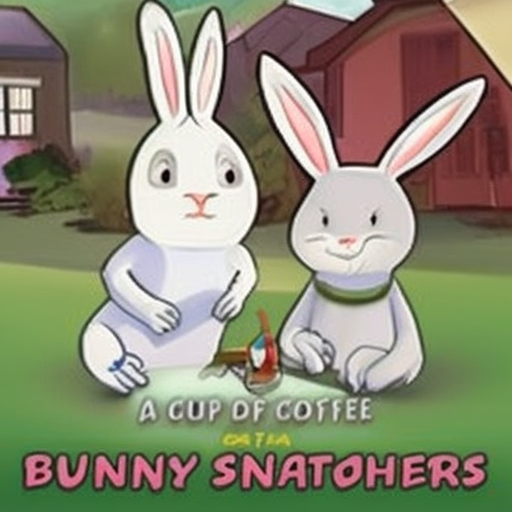

In [3]:
display(output)

In [4]:
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attn_maps, ip_attn_maps, upscale
from collections import defaultdict

target_size = (64,64)

def get_net_attn_map_per_epochs(image_size, batch_size=2, instance_or_negative=False, detach=True, target_processor="ip_attn"):

    idx = 0 if instance_or_negative else 1
    net_attn_maps = defaultdict(list)
    target_attn_map_dict = attn_maps if target_processor == "attn" else ip_attn_maps
    
    # print("target_attn_map_dict: ", target_attn_map_dict.keys())
    if target_processor == "ip_attn":
        for name, attn_map_list in target_attn_map_dict.items():
            print(name)
            if not attn_map_list:
                continue
            
            for i, attn_map in enumerate(attn_map_list):
                print(len(attn_map))
                print(attn_map[0].shape)
                attn_map_1 = attn_map[0].cpu() if detach else attn_map[0]
                attn_map_2 = attn_map[1].cpu() if detach else attn_map[1]
                attn_map_1 = torch.chunk(attn_map_1, batch_size)[idx]
                # .squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                attn_map_2 = torch.chunk(attn_map_2, batch_size)[idx]
                # .squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map_1 = upscale(attn_map_1, target_size)
                upsacled_attn_map_2 = upscale(attn_map_2, target_size)
                net_attn_maps[name + "bbox"].append(upsacled_attn_map_1)
                net_attn_maps[name + "tss"].append(upsacled_attn_map_2)  
    else:
        for name, attn_map_dict in target_attn_map_dict.items():
            if attn_map_dict is None:
                continue
            else:
                attn_map = attn_map_dict # dict{inference_step: ip_attn_map_list}
            
            for _, attn_map in attn_map.items():
                attn_map = attn_map if detach else attn_map[0]
                    
                attn_map = torch.chunk(attn_map, batch_size)[idx].squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map = upscale(attn_map, image_size)
                net_attn_maps[name].append(upsacled_attn_map)

    net_attn_maps = {key: torch.mean(torch.stack(value, dim=0), dim=0) for key, value in net_attn_maps.items()}
    return net_attn_maps

In [5]:
# from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import upscale_maps

# target_size = (64,64)
# def get_attn_maps_per_epochs(image_size, batch_size=2, instance_or_negative=False, detach=True, target_processor="ip_attn"):

#     idx = 0 if instance_or_negative else 1
#     net_attn_maps = defaultdict(list)
#     target_attn_map_dict = attn_maps if target_processor == "attn" else ip_attn_maps
    
#     if target_processor == "ip_attn":
#         for name, attn_map_list in target_attn_map_dict.items():
#             if attn_map_list is None:
#                 continue
            
#             for i, attn_map in enumerate(attn_map_list):
#                 attn_map_1 = attn_map[0].cpu() if detach else attn_map[0]
#                 attn_map_2 = attn_map[1].cpu() if detach else attn_map[1]

#                 print(attn_map_1.shape)
                    
#                 attn_map_1 = torch.chunk(attn_map_1, batch_size)[idx] # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
#                 attn_map_2 = torch.chunk(attn_map_2, batch_size)[idx] # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
#                 upsacled_attn_map_1 = upscale_maps(attn_map_1, target_size)
#                 upsacled_attn_map_2 = upscale_maps(attn_map_2, target_size)
#                 net_attn_maps[name + "_bbox"].append(upsacled_attn_map_1)
#                 net_attn_maps[name + "_tss"].append(upsacled_attn_map_2)  
#     else:
#         for name, attn_map_dict in target_attn_map_dict.items():
#             if attn_map_dict is None:
#                 continue
#             else:
#                 attn_map = attn_map_dict # dict{inference_step: ip_attn_map_list}
            
#             for _, attn_map in attn_map.items():
#                 attn_map = attn_map if detach else attn_map[0]
                    
#                 attn_map = torch.chunk(attn_map, batch_size)[idx].squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
#                 upsacled_attn_map = upscale(attn_map, target_size)
#                 net_attn_maps[name].append(upsacled_attn_map)

#     net_attn_maps = {key: torch.mean(torch.stack(value, dim=0), dim=0) for key, value in net_attn_maps.items()}
#     return net_attn_maps

In [6]:
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attnmaps2images, attnmaps2rgbimages

attn_maps_dict = get_net_attn_map_per_epochs((512, 512))


down_blocks.0.attentions.0.transformer_blocks.0.attn2
2
torch.Size([8, 4096, 16])
attn_map.shape after mean op:  torch.Size([4096, 16])
scale:  1 attn_map.shape:  torch.Size([16, 4096]) temp_w:  64 temp_h 64
scale:  2 attn_map.shape:  torch.Size([16, 4096]) temp_w:  32 temp_h 32
scale:  4 attn_map.shape:  torch.Size([16, 4096]) temp_w:  16 temp_h 16
scale:  8 attn_map.shape:  torch.Size([16, 4096]) temp_w:  8 temp_h 8
scale:  16 attn_map.shape:  torch.Size([16, 4096]) temp_w:  4 temp_h 4
reshaped attn_map.shape:  torch.Size([16, 64, 64])
attn_map.shape after mean op:  torch.Size([4096, 16])
scale:  1 attn_map.shape:  torch.Size([16, 4096]) temp_w:  64 temp_h 64
scale:  2 attn_map.shape:  torch.Size([16, 4096]) temp_w:  32 temp_h 32
scale:  4 attn_map.shape:  torch.Size([16, 4096]) temp_w:  16 temp_h 16
scale:  8 attn_map.shape:  torch.Size([16, 4096]) temp_w:  8 temp_h 8
scale:  16 attn_map.shape:  torch.Size([16, 4096]) temp_w:  4 temp_h 4
reshaped attn_map.shape:  torch.Size([16, 64,

In [10]:
import os
from PIL import Image

# src_image = cv2.imread("text_diffuser/assets/test01.jpeg")
# src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)

src_image = input_image

src_image = np.array(src_image)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
out_image = np.array(output)
attn_hots = []

for k, v in attn_maps_dict.items():
    print(k, len(v))
    out = attnmaps2images(v)
    attn_hots.append(out)
    replaced_k = k.replace(".", "_")
    for i, img in enumerate(out):
        out_path = f"./attn_maps_mask_test/{replaced_k}/attn_map_gray_{i}.png"
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        img.save(out_path)

attn_hots = []

for k, v in attn_maps_dict.items():
    print(k, len(v))
    out = attnmaps2rgbimages(v, out_image)
    attn_hots.append(out)
    replaced_k = k.replace(".", "_")
    for i, img in enumerate(out):
        out_path = f"./attn_maps_mask_test/{replaced_k}/attn_heatmap_{i}.png"
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        img.save(out_path)

down_blocks.0.attentions.0.transformer_blocks.0.attn2bbox 16
down_blocks.0.attentions.0.transformer_blocks.0.attn2tss 16
down_blocks.0.attentions.1.transformer_blocks.0.attn2bbox 16
down_blocks.0.attentions.1.transformer_blocks.0.attn2tss 16
down_blocks.1.attentions.0.transformer_blocks.0.attn2bbox 16
down_blocks.1.attentions.0.transformer_blocks.0.attn2tss 16
down_blocks.1.attentions.1.transformer_blocks.0.attn2bbox 16
down_blocks.1.attentions.1.transformer_blocks.0.attn2tss 16
down_blocks.2.attentions.0.transformer_blocks.0.attn2bbox 16
down_blocks.2.attentions.0.transformer_blocks.0.attn2tss 16
down_blocks.2.attentions.1.transformer_blocks.0.attn2bbox 16
down_blocks.2.attentions.1.transformer_blocks.0.attn2tss 16
mid_block.attentions.0.transformer_blocks.0.attn2bbox 16
mid_block.attentions.0.transformer_blocks.0.attn2tss 16
up_blocks.1.attentions.0.transformer_blocks.0.attn2bbox 16
up_blocks.1.attentions.0.transformer_blocks.0.attn2tss 16
up_blocks.1.attentions.1.transformer_blocks.

In [8]:
# from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attn_maps, ip_attn_maps

# print(ip_attn_maps)

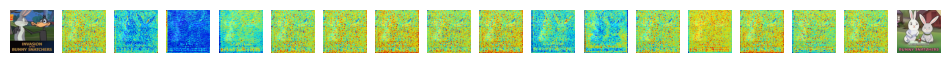

In [9]:
from matplotlib import pyplot as plt
display_images = [input_image] + attn_hots[0] + [output]
fig, axes = plt.subplots(1, len(display_images), figsize=(12, 4))
for axe, image in zip(axes, display_images):
    axe.imshow(image, cmap='gray')
    axe.axis('off')
plt.show()